In [1]:
import time
import torch
import json
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math

from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck, ResNet18_Weights, ResNet34_Weights, resnet18
from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss

import boto3
import io

from models_package.models import Teacher, Student
import models_package
from utils.compare_tools import compare_model_size, compare_inference_time, compare_performance_metrics, plot_comparison
from utils.misc_tools import best_LR, best_LR_wider, train_teacher, train_teacher_wider, retrieve_teacher_class_weights, new_teacher_class_weights

In [2]:
# Hyperparameters
learning_rate = 0.001379 # 0.096779
num_epochs = 240 # 200
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 30
step_size = 30
gamma = 0.1
patience = 7  # for early stopping
lmda = 3
batch_size = 12
num_workers = 4

class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])



In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
len(class_labels)

30

## Test dataloader from utils

In [5]:
from data.data_loader import load_wider

train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']

class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]

trainloader, testloader  = load_wider(train_file, test_file, class_labels, batch_size, num_workers)



Compose(
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [6]:
# from collections import Counter

# # Iterate through batches in the trainloader
# for batch_idx, batch in enumerate(trainloader):
#     # Only process the first 3 batches
#     if batch_idx >= 3:
#         break

#     # Extract labels for the current batch
#     batch_labels = batch['label']

#     # Convert batch_labels to a list if it's not already (e.g., if it's a tensor)
#     if not isinstance(batch_labels, list):
#         batch_labels = batch_labels.tolist()

#     # Count the frequency of each label in this batch
#     label_counts = Counter(batch_labels)

#     # Print the label counts for this batch
#     print(f"Batch {batch_idx + 1} class counts:")
#     for label in range(30):  # Assuming classes are labeled from 0 to 29
#         print(f"  Class {label}: {label_counts[label]} instances")
#     print("-" * 30)  # Just a separator for clarity

# Train Teacher

## Prep s3 bucket

In [7]:
# Calling the function
model_name = 'resnet32x4_wider'
model_weight_path = 'weights/wider_teacher_resnet32x4_weights.pth'
num_class = 30
data_name = 'wider'  
batch_size = 32  
bucket_name = '210bucket'  

## Load in models

### resnet32x4_wider

In [8]:
# Instantiate the models
teacher_name = 'resnet32x4_wider'
teacher_model = models_package.__dict__[teacher_name](num_class=30)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 30)

### resnet8x4_wider

In [13]:
student_name = 'resnet8x4_wider'
student_model = models_package.__dict__[student_name](num_class=30)
student_model.fc = nn.Linear(teacher_model.fc.in_features, 30)

In [14]:
# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# teacher_lr = best_LR_wider('resnet32x4_lr_wider_test', teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=3)
# teacher_lr

100%|██████████████████████████████████████████████████████████████████████████████████████| 861/861 [01:07<00:00, 12.75it/s]


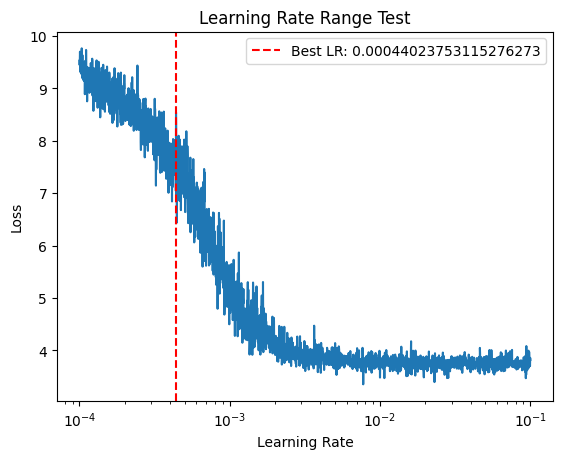

Best learning rate: 0.00044023753115276273


0.00044023753115276273

In [16]:
student_lr = best_LR_wider('resnet8x4_lr_wider_test', student_model, trainloader, criterion, student_optimizer, student_scheduler, device, num_epochs=3)
student_lr

In [13]:
teacher_lr = 0.0005953788301881531
student_lr = 0.0011397725198066264

## Train Leaderboard Teacher Models

In [14]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

In [42]:
# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, epochs, patience=5):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        model.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            _, outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1


        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)


        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0  
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
    
                # Forward pass for validation
                _, val_outputs = model(val_inputs)
    
                val_loss = criterion(val_outputs, val_labels)

                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
            total_val_loss /= num_batches
            val_losses.append(total_val_loss)
            accuracy = total_correct / total_samples
            print(f'*****Epoch {epoch + 1}/{num_epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n')
        # Check for early stopping
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            patience_counter = 0 
            torch.save(model.state_dict(), f'weights/wider/wider_teacher_model_weights_resnet32_4_v2.pth')
            torch.save(model, f'weights/wider/wider_teacher_model_resnet32_4.pth')
        else:
            patience_counter += 1 

        if (patience_counter >= patience):
            print('Early stopping')
            break  

        scheduler.step()
    plot_loss_curve(val_losses)
    print("Finished Training Teacher")

100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.12it/s]


*****Epoch 1/240*****
*****Train Loss:  2.975912 Val Loss:  2.832626*****
*****Validation Accuracy: 24.36%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.16it/s]


*****Epoch 2/240*****
*****Train Loss:  2.867775 Val Loss:  2.683564*****
*****Validation Accuracy: 28.24%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.16it/s]


*****Epoch 3/240*****
*****Train Loss:  2.782932 Val Loss:  2.592292*****
*****Validation Accuracy: 29.71%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.15it/s]


*****Epoch 4/240*****
*****Train Loss:  2.726390 Val Loss:  2.525979*****
*****Validation Accuracy: 31.89%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.15it/s]


*****Epoch 5/240*****
*****Train Loss:  2.675066 Val Loss:  2.474137*****
*****Validation Accuracy: 33.25%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.14it/s]


*****Epoch 6/240*****
*****Train Loss:  2.622394 Val Loss:  2.351434*****
*****Validation Accuracy: 35.59%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.15it/s]


*****Epoch 7/240*****
*****Train Loss:  2.568667 Val Loss:  2.436075*****
*****Validation Accuracy: 33.04%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.14it/s]


*****Epoch 8/240*****
*****Train Loss:  2.535881 Val Loss:  2.256840*****
*****Validation Accuracy: 37.68%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.14it/s]


*****Epoch 9/240*****
*****Train Loss:  2.495550 Val Loss:  2.275010*****
*****Validation Accuracy: 37.88%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.16it/s]


*****Epoch 10/240*****
*****Train Loss:  2.459619 Val Loss:  2.190971*****
*****Validation Accuracy: 40.43%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.16it/s]


*****Epoch 11/240*****
*****Train Loss:  2.403540 Val Loss:  2.076430*****
*****Validation Accuracy: 42.95%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.16it/s]


*****Epoch 12/240*****
*****Train Loss:  2.360690 Val Loss:  2.041436*****
*****Validation Accuracy: 42.86%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.16it/s]


*****Epoch 13/240*****
*****Train Loss:  2.329874 Val Loss:  1.953692*****
*****Validation Accuracy: 45.67%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.15it/s]


*****Epoch 14/240*****
*****Train Loss:  2.293178 Val Loss:  1.879885*****
*****Validation Accuracy: 47.32%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.17it/s]


*****Epoch 15/240*****
*****Train Loss:  2.261333 Val Loss:  1.994657*****
*****Validation Accuracy: 47.47%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.16it/s]


*****Epoch 16/240*****
*****Train Loss:  2.232436 Val Loss:  1.848849*****
*****Validation Accuracy: 49.41%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.15it/s]


*****Epoch 17/240*****
*****Train Loss:  2.178093 Val Loss:  1.835918*****
*****Validation Accuracy: 50.65%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.16it/s]


*****Epoch 18/240*****
*****Train Loss:  2.150956 Val Loss:  1.670328*****
*****Validation Accuracy: 53.95%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.16it/s]


*****Epoch 19/240*****
*****Train Loss:  2.121356 Val Loss:  1.651692*****
*****Validation Accuracy: 53.95%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.17it/s]


*****Epoch 20/240*****
*****Train Loss:  2.078157 Val Loss:  1.662508*****
*****Validation Accuracy: 55.84%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.16it/s]


*****Epoch 21/240*****
*****Train Loss:  2.053295 Val Loss:  1.609030*****
*****Validation Accuracy: 56.10%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.19it/s]


*****Epoch 22/240*****
*****Train Loss:  2.013248 Val Loss:  1.454697*****
*****Validation Accuracy: 59.08%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 23/240*****
*****Train Loss:  1.977214 Val Loss:  1.505149*****
*****Validation Accuracy: 60.30%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.20it/s]


*****Epoch 24/240*****
*****Train Loss:  1.935430 Val Loss:  1.376626*****
*****Validation Accuracy: 61.45%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.19it/s]


*****Epoch 25/240*****
*****Train Loss:  1.927781 Val Loss:  1.283436*****
*****Validation Accuracy: 63.48%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.19it/s]


*****Epoch 26/240*****
*****Train Loss:  1.876700 Val Loss:  1.282284*****
*****Validation Accuracy: 64.61%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.20it/s]


*****Epoch 27/240*****
*****Train Loss:  1.849552 Val Loss:  1.200790*****
*****Validation Accuracy: 65.13%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.19it/s]


*****Epoch 28/240*****
*****Train Loss:  1.814569 Val Loss:  1.123950*****
*****Validation Accuracy: 68.93%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.19it/s]


*****Epoch 29/240*****
*****Train Loss:  1.779098 Val Loss:  1.053810*****
*****Validation Accuracy: 70.84%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.20it/s]


*****Epoch 30/240*****
*****Train Loss:  1.741138 Val Loss:  1.017972*****
*****Validation Accuracy: 72.37%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.20it/s]


*****Epoch 31/240*****
*****Train Loss:  1.511468 Val Loss:  0.788739*****
*****Validation Accuracy: 78.89%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.19it/s]


*****Epoch 32/240*****
*****Train Loss:  1.446959 Val Loss:  0.726977*****
*****Validation Accuracy: 80.34%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 33/240*****
*****Train Loss:  1.420945 Val Loss:  0.766250*****
*****Validation Accuracy: 80.28%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 34/240*****
*****Train Loss:  1.413108 Val Loss:  0.681158*****
*****Validation Accuracy: 82.13%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.17it/s]


*****Epoch 35/240*****
*****Train Loss:  1.395909 Val Loss:  0.659833*****
*****Validation Accuracy: 82.88%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 36/240*****
*****Train Loss:  1.384891 Val Loss:  0.629670*****
*****Validation Accuracy: 83.23%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 37/240*****
*****Train Loss:  1.376336 Val Loss:  0.632562*****
*****Validation Accuracy: 83.46%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 38/240*****
*****Train Loss:  1.342710 Val Loss:  0.616038*****
*****Validation Accuracy: 83.96%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 39/240*****
*****Train Loss:  1.344695 Val Loss:  0.641235*****
*****Validation Accuracy: 84.33%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.19it/s]


*****Epoch 40/240*****
*****Train Loss:  1.319341 Val Loss:  0.578644*****
*****Validation Accuracy: 85.38%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 41/240*****
*****Train Loss:  1.308076 Val Loss:  0.585056*****
*****Validation Accuracy: 85.87%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 42/240*****
*****Train Loss:  1.314618 Val Loss:  0.537000*****
*****Validation Accuracy: 86.71%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 43/240*****
*****Train Loss:  1.292363 Val Loss:  0.554035*****
*****Validation Accuracy: 86.65%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 44/240*****
*****Train Loss:  1.277977 Val Loss:  0.621968*****
*****Validation Accuracy: 86.71%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 45/240*****
*****Train Loss:  1.283398 Val Loss:  0.534673*****
*****Validation Accuracy: 87.69%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.19it/s]


*****Epoch 46/240*****
*****Train Loss:  1.275791 Val Loss:  0.601946*****
*****Validation Accuracy: 87.84%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.17it/s]


*****Epoch 47/240*****
*****Train Loss:  1.269344 Val Loss:  0.490451*****
*****Validation Accuracy: 89.23%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 48/240*****
*****Train Loss:  1.245756 Val Loss:  0.537412*****
*****Validation Accuracy: 88.82%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.17it/s]


*****Epoch 49/240*****
*****Train Loss:  1.224669 Val Loss:  0.473802*****
*****Validation Accuracy: 90.18%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.17it/s]


*****Epoch 50/240*****
*****Train Loss:  1.207268 Val Loss:  0.521587*****
*****Validation Accuracy: 89.17%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.17it/s]


*****Epoch 51/240*****
*****Train Loss:  1.215481 Val Loss:  0.555573*****
*****Validation Accuracy: 88.97%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 52/240*****
*****Train Loss:  1.204829 Val Loss:  0.480271*****
*****Validation Accuracy: 90.30%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.19it/s]


*****Epoch 53/240*****
*****Train Loss:  1.170098 Val Loss:  0.377572*****
*****Validation Accuracy: 91.72%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 54/240*****
*****Train Loss:  1.186692 Val Loss:  0.509643*****
*****Validation Accuracy: 90.67%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 55/240*****
*****Train Loss:  1.162618 Val Loss:  0.473375*****
*****Validation Accuracy: 91.40%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.17it/s]


*****Epoch 56/240*****
*****Train Loss:  1.155412 Val Loss:  0.464141*****
*****Validation Accuracy: 91.78%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 57/240*****
*****Train Loss:  1.136737 Val Loss:  0.425121*****
*****Validation Accuracy: 92.85%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 58/240*****
*****Train Loss:  1.122533 Val Loss:  0.445387*****
*****Validation Accuracy: 91.80%*****

Early stopping


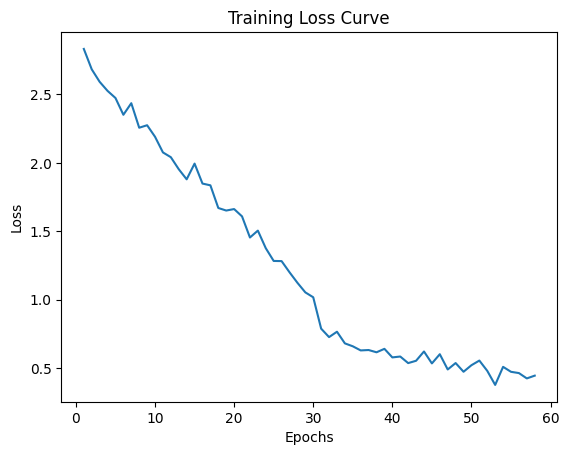

Finished Training Teacher


In [43]:
train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs, patience=5)

In [15]:
## backup locally
# Save the student and teacher model weights and architecture
torch.save(teacher_model.state_dict(), 'weights/wider/wider_teacher_model_weights_resnet32_4.pth')
torch.save(teacher_model, 'weights/wider/wider_teacher_model_resnet32_4.pth')
print('student weights and architecture saved and exported')

student weights and architecture saved and exported


In [8]:
## load model 
teacher_name = 'resnet32x4_wider'
teacher_model = models_package.__dict__[teacher_name](num_class=30)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 30)

teacher_model.load_state_dict(torch.load('weights/wider/wider_teacher_model_weights_resnet32_4_v2.pth'))

<All keys matched successfully>

In [9]:
###################### Saving weights and movel using s3 bucket ######################

session = boto3.session.Session()
s3 = session.client('s3')

bucket_name = '210bucket' 



# Teacher Model
#### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
teacher_model_weights_path = 'weights/teacher_model_resnet32x4_wider.pth'
teacher_model_path = 'models/testing_teacher_model_resnet32x4_wider.pth'

# Save state dict to buffer
teacher_model_weights_buffer = io.BytesIO()
torch.save(teacher_model.state_dict(), teacher_model_weights_buffer)
teacher_model_weights_buffer.seek(0)

# Save entire model to buffer
teacher_model_buffer = io.BytesIO()
torch.save(teacher_model, teacher_model_buffer)
teacher_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=teacher_model_weights_path, Body=teacher_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=teacher_model_path, Body=teacher_model_buffer)
print('teacher weights and architecture saved and exported to S3')


teacher weights and architecture saved and exported to S3


## Model Evaluation

### Pull Model from S3

In [13]:
# Initialize a session using Boto3 again 
session = boto3.session.Session()

s3 = session.client('s3')
bucket_name = '210bucket'  

teacher_model_weights_s3_path = 'weights/teacher_model_resnet32x4_wider.pth'
# student_model_weights_s3_path = 'weights/testing_student_model_weights_rkd_prof.pth'

# Read files directly into memory
teacher_model_weights_buffer = io.BytesIO()
# student_model_weights_buffer = io.BytesIO()

s3.download_fileobj(bucket_name, teacher_model_weights_s3_path, teacher_model_weights_buffer)
# s3.download_fileobj(bucket_name, student_model_weights_s3_path, student_model_weights_buffer)

# Load the weights into the models
teacher_model_weights_buffer.seek(0)  # Move to the beginning of the buffer
# student_model_weights_buffer.seek(0)  

######## MAKE SURE THAT YOU HAVE THE CORRECT MODELS FOR WEIGHTS ########
# Teacher
teacher_name = 'resnet32x4_wider'
teacher_model = models_package.__dict__[teacher_name](num_class=30)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 30)
teacher_model.load_state_dict(torch.load(teacher_model_weights_buffer))
teacher_model.eval()
# # Student
# student_model = CustomResNet18()
# student_model.load_state_dict(torch.load(student_model_weights_buffer))


ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [11]:

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs[0], dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs[0], dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }
    
def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.show()

{'accuracy': (0.0002896032435563278, 0.04749493194323776), 'precision': (0.0333043730089777, 0.03524271768918605), 'recall': (0.0002896032435563278, 0.04749493194323776), 'f1': (0.0005742133277409949, 0.02712950434173754)}


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


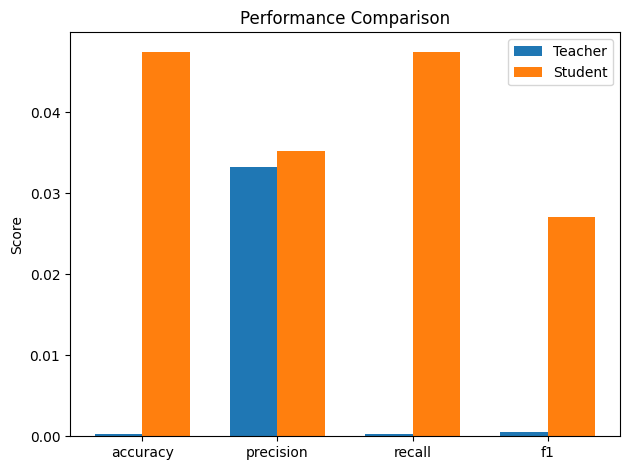

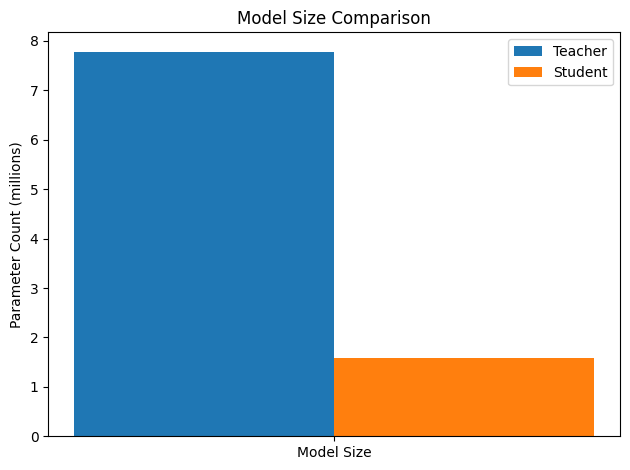

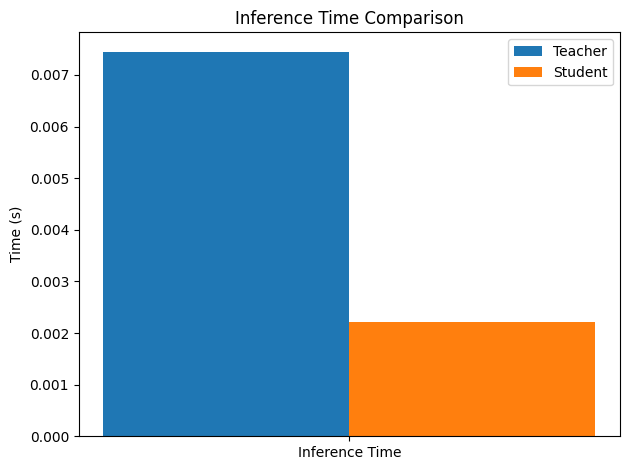

In [17]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)['metrics']
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]

student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')